# LIVER DISEASE DETERMINATION - Bupa Blood Test Data

## Dataset Overview

### Dataset Information

The first 5 variables are all blood tests which are thought to be sensitive to liver disorders that might arise from excessive alcohol consumption. Each line in the dataset constitutes the record of a single male individual.

Important note: The 7th field (selector) has been widely misinterpreted in the past as a dependent variable representing presence or absence of a liver disorder. This is incorrect [1]. The 7th field was created by BUPA researchers as a train/test selector. It is not suitable as a dependent variable for classification. The dataset does not contain any variable representing presence or absence of a liver disorder. Researchers who wish to use this dataset as a classification benchmark should follow the method used in experiments by the donor (Forsyth & Rada, 1986, Machine learning: applications in expert systems and information retrieval) and others (e.g. Turney, 1995, Cost-sensitive classification: Empirical evaluation of a hybrid genetic decision tree induction algorithm), who used the 6th field (drinks), after dichotomising, as a dependent variable for classification. Because of widespread misinterpretation in the past, researchers should take care to state their method clearly.

### Attribute Information

1. mcv - mean corpuscular volume
2. alkphos - alkaline phosphotase
3. sgpt - alanine aminotransferase
4. sgot - aspartate aminotransferase
5. gammagt - gamma-glutamyl transpeptidase
6. alcohol_cons - drinks number of half-pint equivalents of alcoholic beverages drunk per day
7. selector_field - created by the BUPA researchers to split the data into train/test sets

### Data Location

* Data available from https://archive.ics.uci.edu/ml/datasets/Liver+Disorders

## NoteBook Set-Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use("fivethirtyeight")

In [2]:
# Import the data - strip each line of \n and split into 7 columns 
with open(r"bupa.data") as fp:
    df = pd.DataFrame([line.strip("\n").split(maxsplit=7, sep=",") for line in fp])

## Data Preparation

In [3]:
col_names = ["mcv", "alkphos", "sgpt", "sgot", "gammagt", "alcohol_cons", "selector_field"]
df.columns = col_names # Set the column titles from the list defined above

In [4]:
selector_col = df.pop("selector_field") # Remove the 'target' variable
df = df.astype("float") # Ensure all features are treated as float type

In [5]:
df.head() # Provide a brief preview of the data generated

,mcv,alkphos,sgpt,sgot,gammagt,alcohol_cons
0,85.0,92.0,45.0,27.0,31.0,0.0
1,85.0,64.0,59.0,32.0,23.0,0.0
2,86.0,54.0,33.0,16.0,54.0,0.0
3,91.0,78.0,34.0,24.0,36.0,0.0
4,87.0,70.0,12.0,28.0,10.0,0.0


In [6]:
print("----------------------------")
print("Dataset Summary")
print("----------------------------")
print("Total number of samples: {}".format(df.shape[0]))
print("Total number of columns: {}".format(df.shape[1]))
print("----------------------------")

----------------------------
Dataset Summary
----------------------------
Total number of samples: 345
Total number of columns: 6
----------------------------


## Initial Insights

In [7]:
use_cols = ["mcv", "alkphos", "sgpt", "sgot", "gammagt", "alcohol_cons"]

### Histograms

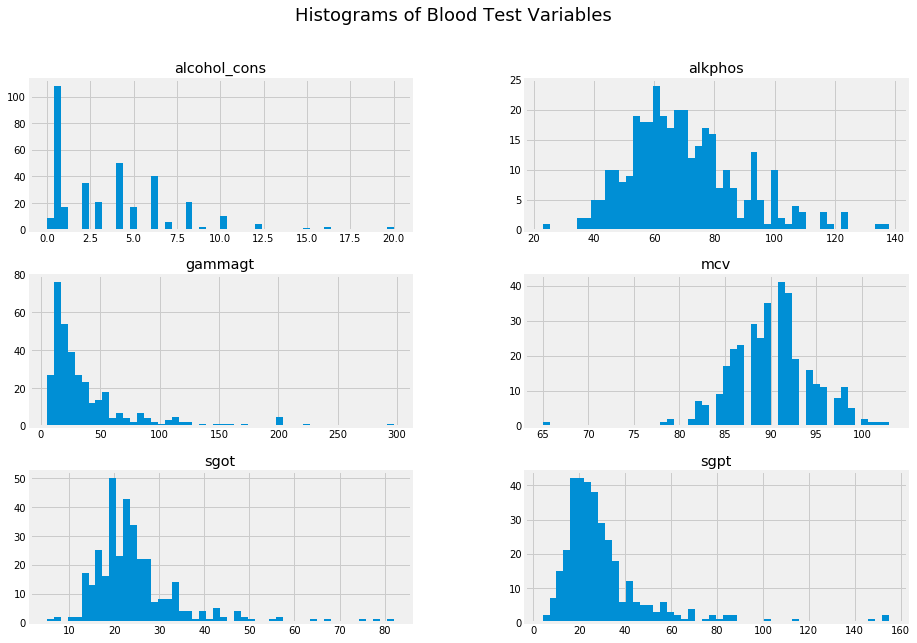

In [8]:
import pylab
axes = df.hist(bins=50, figsize=(14, 10)) # histogram view of each feature that we have
_ = pylab.suptitle("Histograms of Blood Test Variables", size=18)

### Correlation Matrix

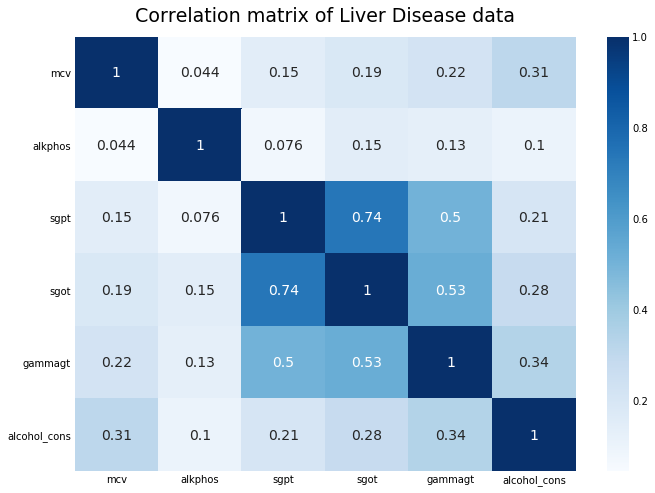

In [9]:
corrMatrix = df[use_cols].corr()
plt.subplots(figsize=(10, 8))
plt.title("Correlation matrix of Liver Disease data", y=1.02, size=19)
sns.heatmap(corrMatrix, annot_kws={"fontsize": 14}, annot=True, cmap="Blues")
plt.yticks(rotation=0)
plt.show()

## K-Means Clustering

### Scaled Features

* Before applying any clustering type methods, we need to first scale the available features to ensure consistency, an essential step
* Here we scale the features to a range between 0 and 1, as is common practice within the field

In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [11]:
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df),
                         columns=use_cols) # Scaled the columns in the df, and set names

In [12]:
scaled_df.head() # Quick preview to show the scaled features

,mcv,alkphos,sgpt,sgot,gammagt,alcohol_cons
0,0.526316,0.600000,0.271523,0.285714,0.089041,0.0
1,0.526316,0.356522,0.364238,0.350649,0.061644,0.0
2,0.552632,0.269565,0.192053,0.142857,0.167808,0.0
3,0.684211,0.478261,0.198675,0.246753,0.106164,0.0
4,0.578947,0.408696,0.052980,0.298701,0.017123,0.0


### Find the Suitable Number of Clusters to Utilise

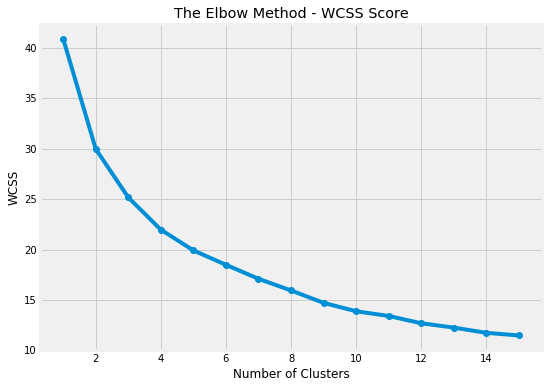

In [13]:
# Find the appropriate cluster number
plt.figure(figsize=(8, 6))
max_n=15
wcss = []
for n in range(1, max_n+1):
    kmeans = KMeans(n_clusters=n, init="k-means++", random_state=42)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, max_n+1), wcss, marker="o")
plt.title("The Elbow Method - WCSS Score")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

* With the above plot we would ideally pick a clear "elbow point", being a point where we see a clear shift in the angle of the line
* Based on the above plot it is difficult to pick a clear point where this occurs
* For arguments sake we can pick a value of 3 for use in the clustering process below

### K-Means Clustering

In [14]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(scaled_df) # Fit k-means cluster to the scaled dataset

In [15]:
centroids = kmeans.cluster_centers_ # Store the cluster centers
labels = kmeans.predict(scaled_df) # Generate labels for each row of data
scaled_df["k_group"] = labels # Assign these labels to the new column in the main dataframe

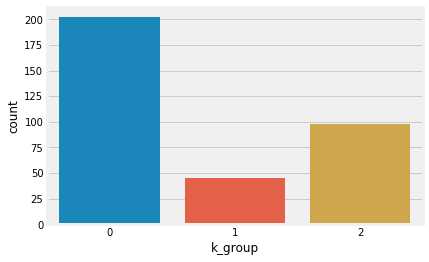

In [16]:
sns.countplot(data=scaled_df, x="k_group")

### Visualise Insights

In [17]:
color_dict = dict({0: "red",
                   1: "green",
                   2: "blue"}) # Assign a dictionary for colour assignment

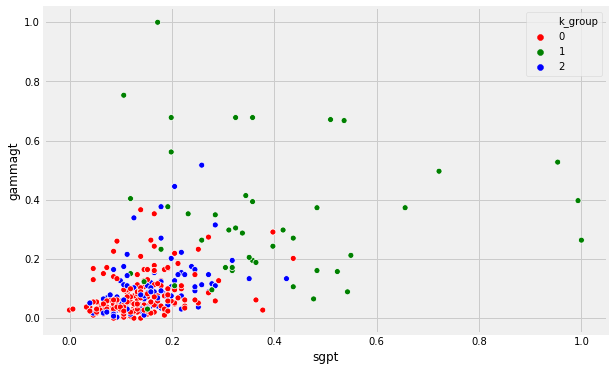

In [18]:
plt.subplots(figsize=(9, 6))
sns.scatterplot(x="sgpt", y="gammagt", hue="k_group", palette=color_dict, data=scaled_df)

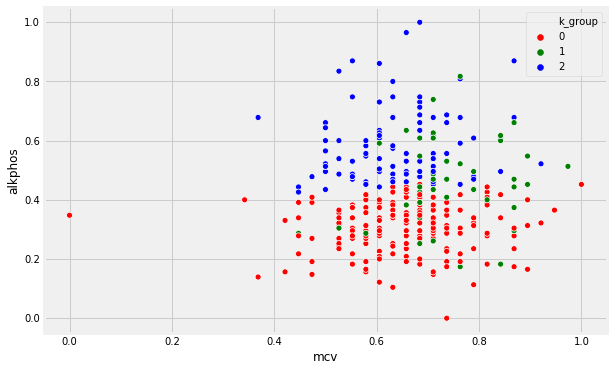

In [19]:
plt.subplots(figsize=(9, 6))
sns.scatterplot(x="mcv", y="alkphos", hue="k_group", palette=color_dict, data=scaled_df)

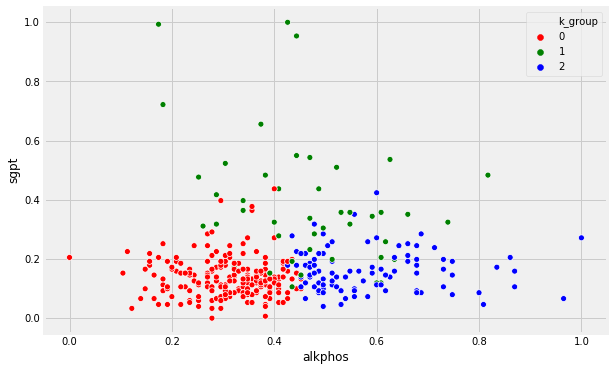

In [20]:
plt.subplots(figsize=(9, 6))
sns.scatterplot(x="alkphos", y="sgpt", hue="k_group", palette=color_dict, data=scaled_df)

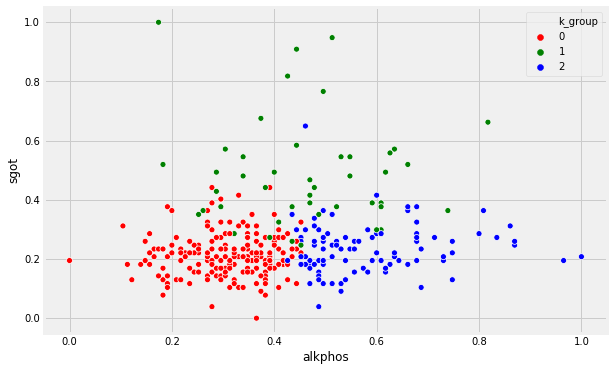

In [21]:
plt.subplots(figsize=(9, 6))
sns.scatterplot(x="alkphos", y="sgot", hue="k_group", palette=color_dict, data=scaled_df)

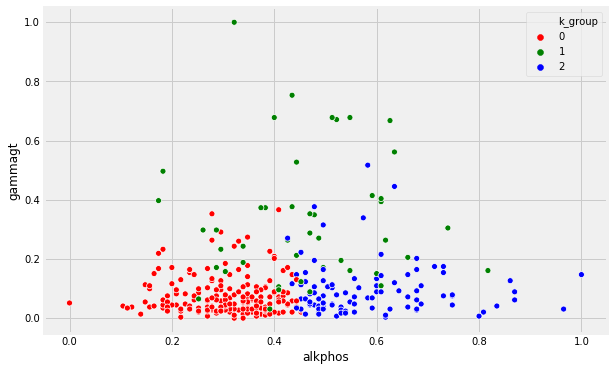

In [22]:
plt.subplots(figsize=(9, 6))
sns.scatterplot(x="alkphos", y="gammagt", hue="k_group", palette=color_dict, data=scaled_df)

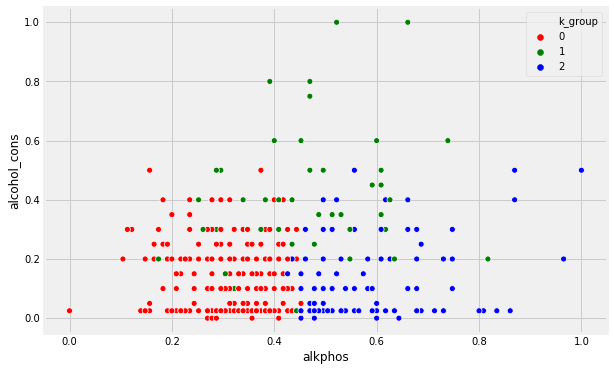

In [23]:
plt.subplots(figsize=(9, 6))
sns.scatterplot(x="alkphos", y="alcohol_cons", hue="k_group", palette=color_dict, data=scaled_df)

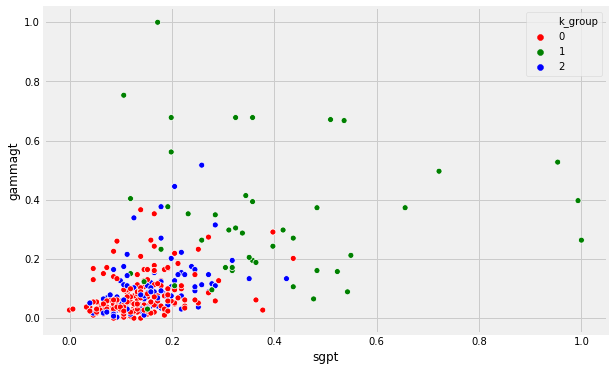

In [24]:
plt.subplots(figsize=(9, 6))
sns.scatterplot(x="sgpt", y="gammagt", hue="k_group",
                palette=color_dict, data=scaled_df)

# Data Understanding of Groupings

In [25]:
from matplotlib.figure import Figure
plot_features = list(set(scaled_df.columns))
plot_features.remove("k_group")

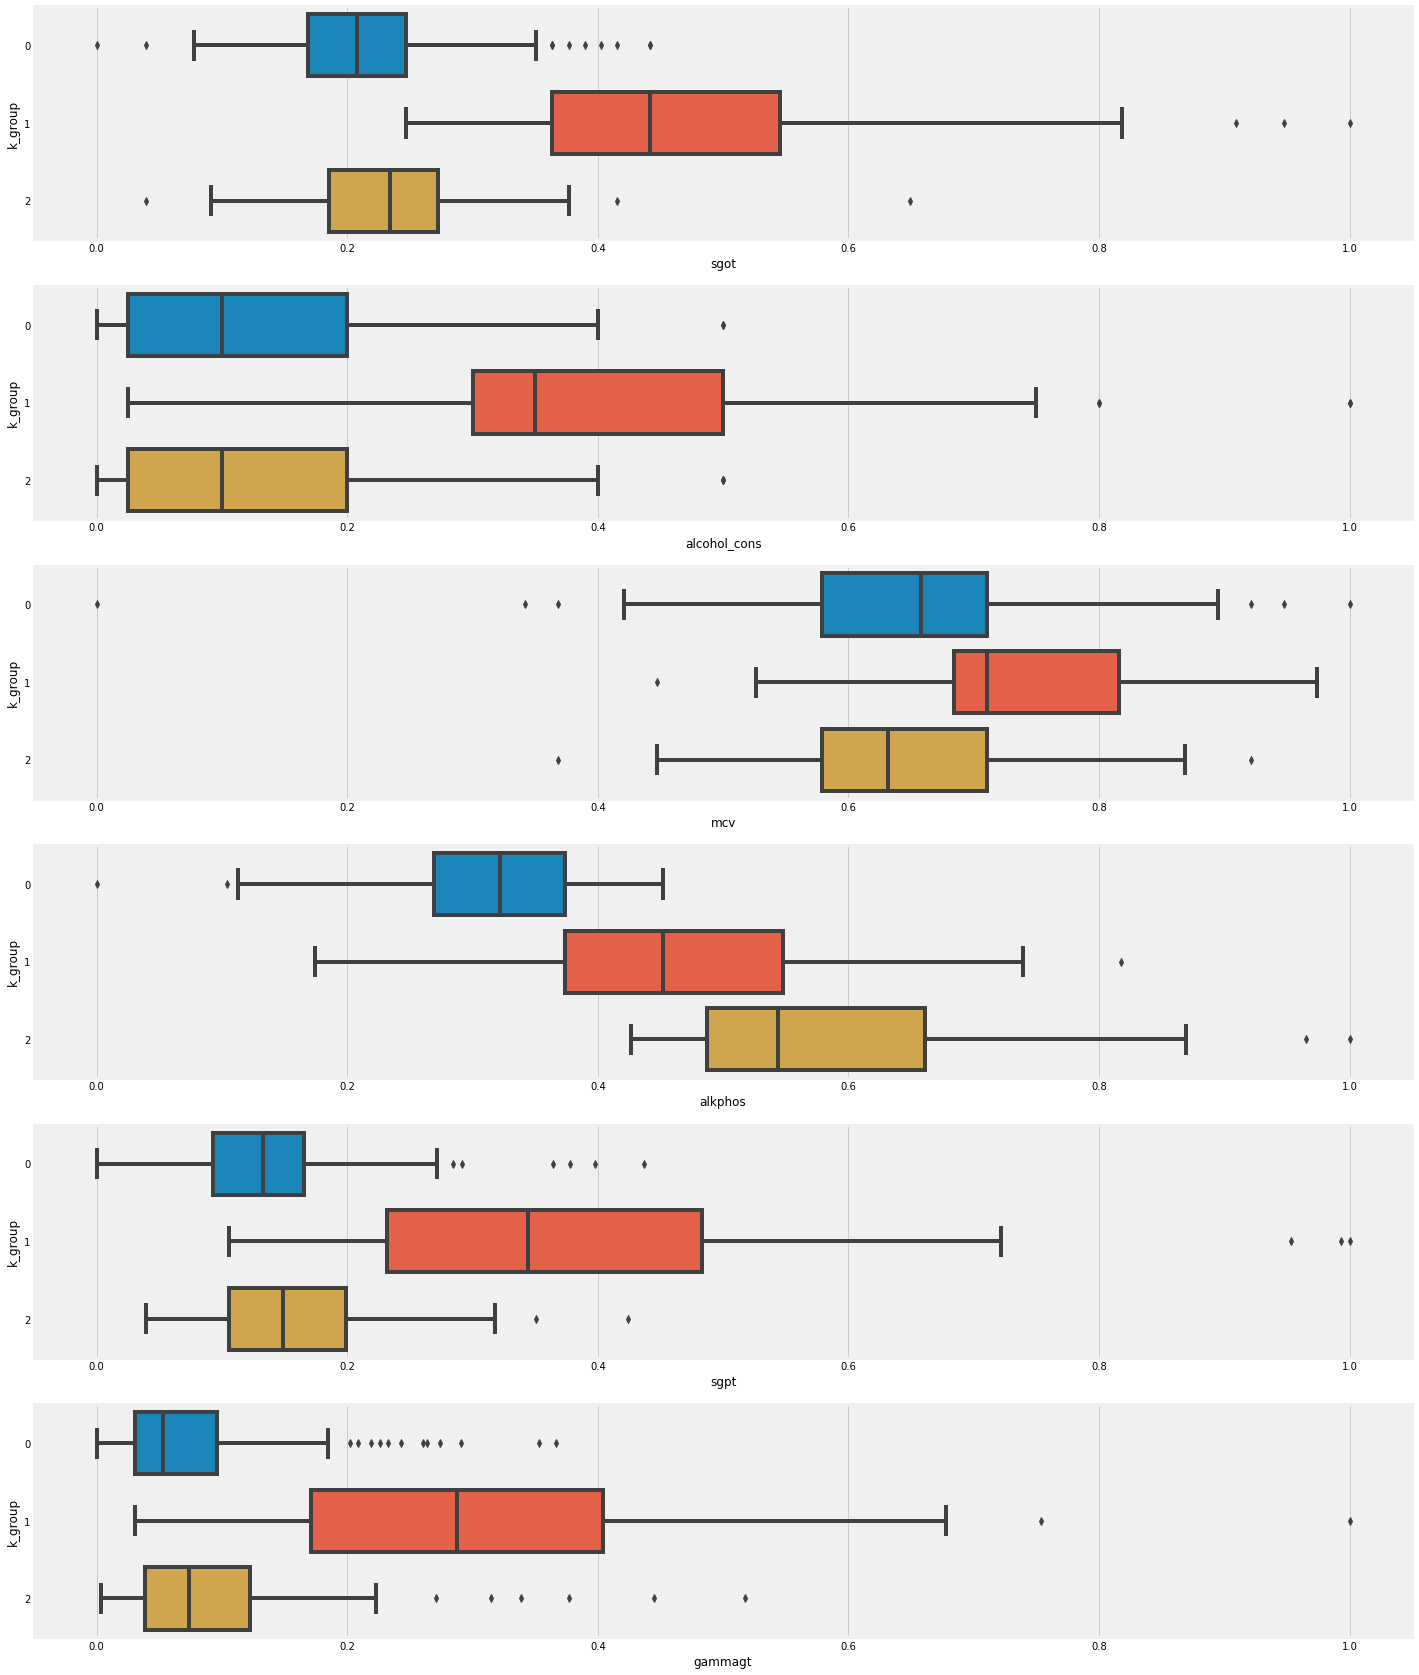

In [26]:
fig, ax = plt.subplots(nrows=len(plot_features), figsize=(22, 30))
for i, j in enumerate(plot_features):
    sns.boxplot(data=scaled_df, y="k_group", x=j, orient="h", ax=ax[i])

/Users/alessiomorteo/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 1152x720 with 0 Axes>

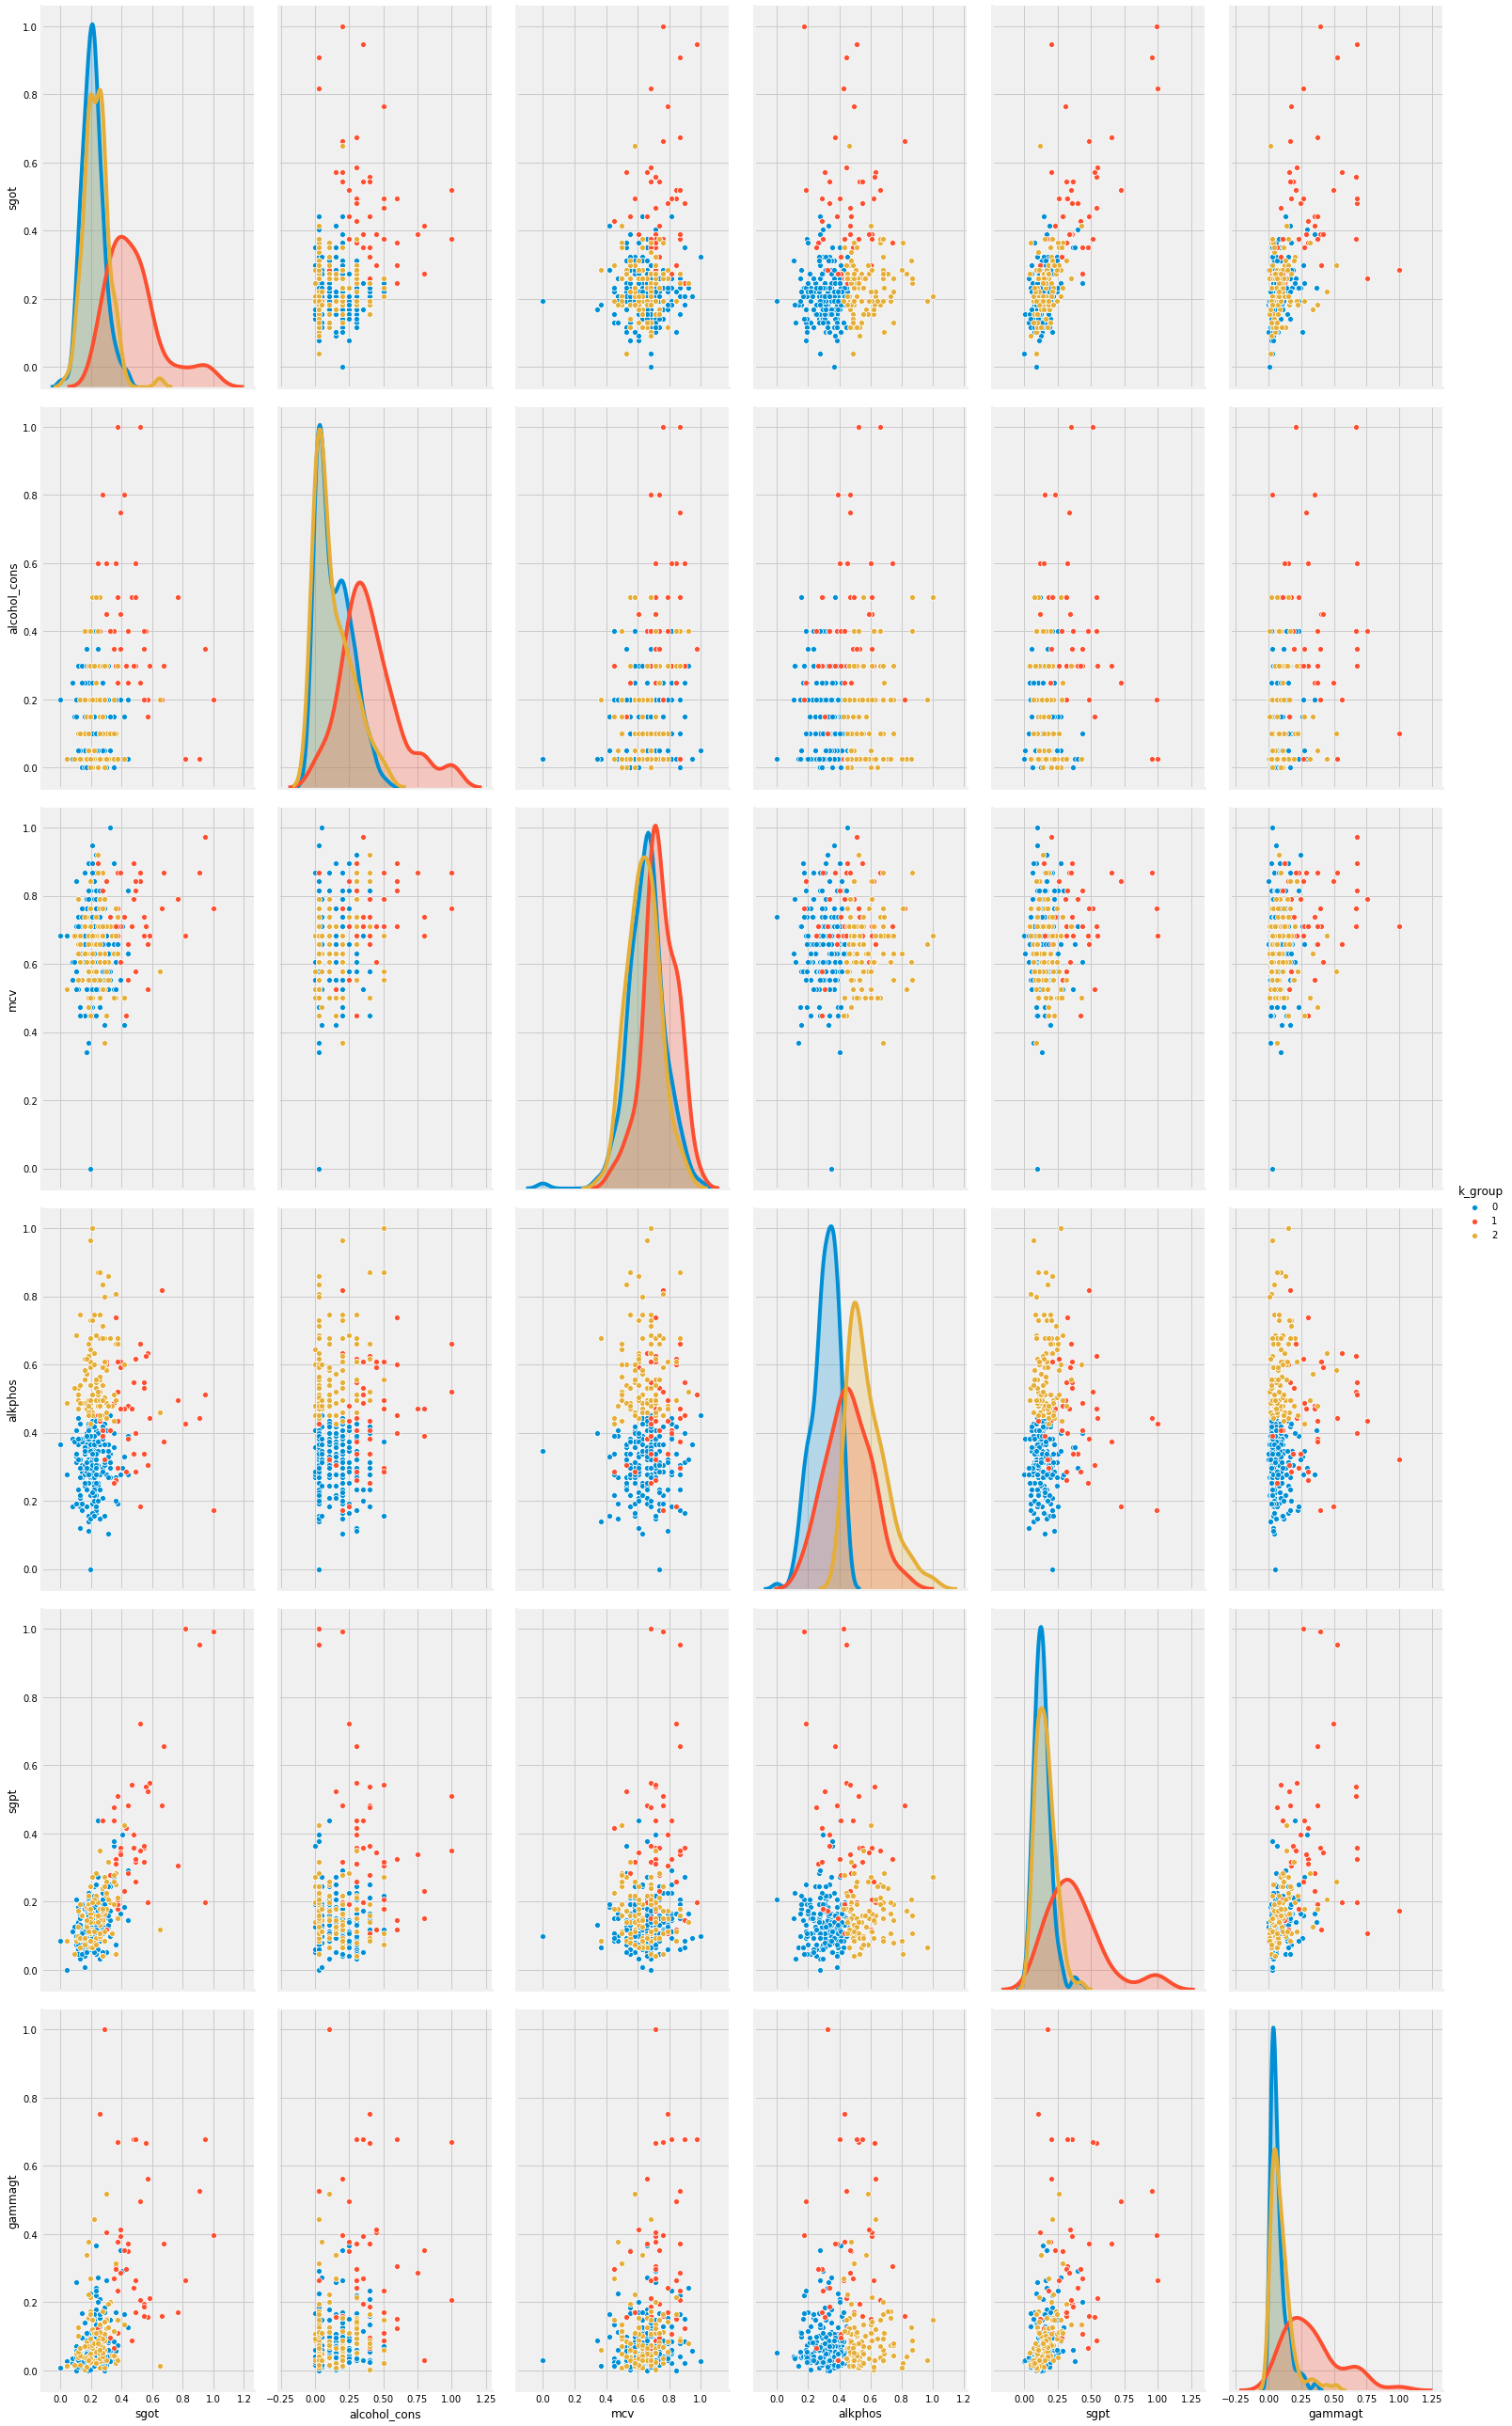

In [27]:
plt.figure(figsize=(16, 10))
_ = sns.pairplot(scaled_df, hue="k_group", vars=plot_features, height=6, aspect=0.6)

### Insights
* Alkphos alkaline phosphotase - raised with poor liver function (Raised levels of ALP are usually due to a disorder of either the bone or liver)
* Alanine aminotrasnferase - When the liver is damaged, ALT is released into the bloodstream. 
* Aspartate aminotransferase - Body releases more when your liver is damaged
* MCV - how big are the red blood cells (erythrocytes), increases with alcohol consumption - 80-96 is normal
* GGT is high with liver damage.


## MODELLING - Random Forest Classifier (RF)

### Set-Up

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
scaled_df["k_group"] = scaled_df["k_group"].astype("int") # Target is considered as an integer type

In [30]:
# Split dataset into Training Set and Test Set
X_train, X_test, y_train, y_test = train_test_split(scaled_df[use_cols],
                                                    scaled_df["k_group"],
                                                    test_size=0.25,
                                                    random_state=42)

### Train Model

In [31]:
# Fit model to the training data
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=10, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

### Model Predictions

In [32]:
y_pred = model.predict(X_test) # Make a prediction on each test set instance
predictions = [round(value) for value in y_pred] # Round the values

In [33]:
class_probabilities = pd.DataFrame(model.predict_proba(X_test)) # Obtain class probabilities for the x_test
for i in range(2):  
    class_probabilities.iloc[:, i] = (class_probabilities.iloc[:, i] * 100) # Convert to a percentage format

In [34]:
class_probabilities.head()

,0,1,2
0,98.0,0.0,0.02
1,4.0,43.0,0.53
2,99.0,0.0,0.01
3,4.0,0.0,0.96
4,5.0,5.0,0.90


### Model Performance

In [35]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [36]:
print("----------------------------")
print("MODEL PERFORMANCE SUMMARY")
print("----------------------------")
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, predictions) * 100.0))
print("F1: {:.3f}".format(f1_score(y_test, predictions, average="weighted")))
print("F1 (macro): {:.3f}".format(f1_score(y_test, predictions, average="macro")))
print("----------------------------")

----------------------------
MODEL PERFORMANCE SUMMARY
----------------------------
Accuracy: 95.40%
F1: 0.950
F1 (macro): 0.915
----------------------------


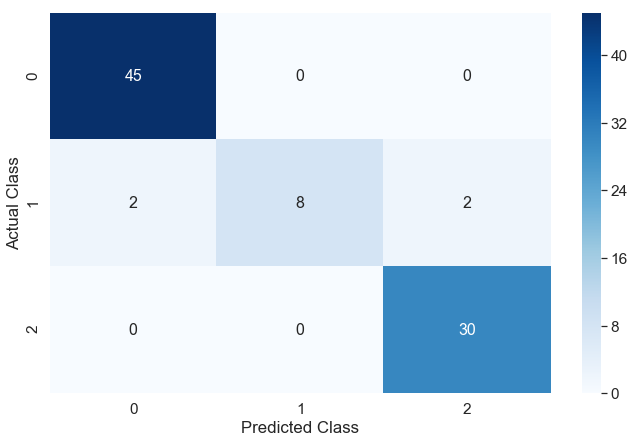

In [37]:
df_cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.4)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues") # Generate the confusion matrix plot
_ = ax.set(xlabel="Predicted Class", ylabel="Actual Class") # Assign x and y axis labels

### Feature Importance

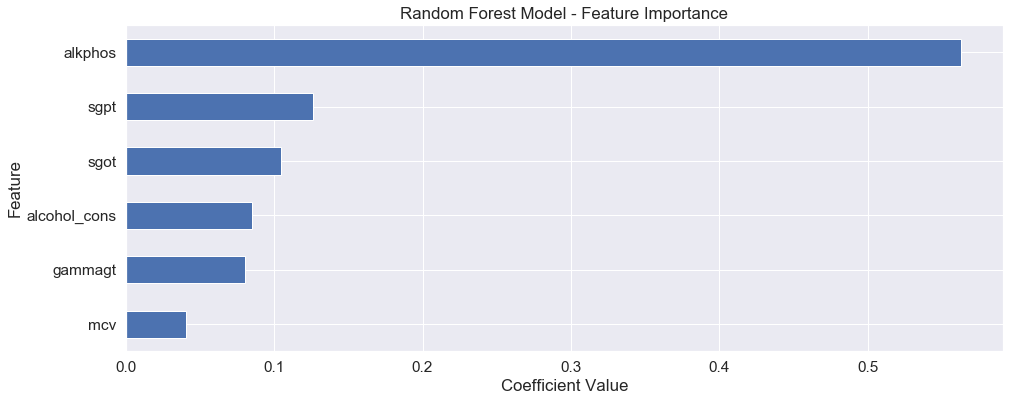

In [38]:
model_coefficients = pd.Series(model.feature_importances_, index=use_cols) # Store coefficients in dataframe using column labels for each respective coefficient
model_coefficients.sort_values(ascending=True).plot(kind="barh", figsize=(14, 6)) # Plot feature importance
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
_ = plt.title("Random Forest Model - Feature Importance")